# WBO Interpolation 

Openforcefield is interested in implementation of wbo interpolated parameters. These torsion parameters calculate the wbo between the two cetral atoms invovled in a torsion. WBO correlates with the torsion barrier height and also captures the behavior of remote chemical properties which allowing for potential reduction of parameters and improved accuracy. 

### Calculation of k
- For each molecule the torsion is checked to match TIG-fit0, and then checks if the application of the torsion is 4-fold around the torsion match
- The script sets up a forcebalance optimization for a single torsion targets and performs the optimization
- The k value is parsed from the .offxml optimized torsion TIG-fit0



In [1]:
#imports 
import os
import json
import tempfile
from openforcefield.typing.engines.smirnoff import (ForceField,
UnassignedValenceParameterException, BondHandler, AngleHandler,
ProperTorsionHandler, ImproperTorsionHandler,
vdWHandler)
from plot_td_energies import collect_td_targets_data, plot_td_targets_data
from fragmenter.utils import HARTREE_2_KJMOL
import pickle
import shutil
from openforcefield.topology import Molecule, Topology
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
force_balance_file = 'optimize.in'
from make_torsion_target_new import *
from openforcefield.topology import Molecule, Topology
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import qcportal as ptl
import gzip

Note: Failed to import the optional openff.recharge package.


In [2]:
def genData(ff, ff2):
    """
    Definition: Generate the kvalue from forcebalance runs for each molecule in the target directory 
    
    ff: The force field used for forcebalance runs, includes "TIG-fit0" parameter 
    ff2: The force field used for labeling torsion parameters for analysis, for example force field with full wbo interpolated parameters 
    """
    #clear out target directory to create new targets based on dataset specifications 
    #shutil.rmtree(target_directory)
    #os.mkdir(target_directory)
    ff_path = '/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/openff-1.3.0.offxml'
    directory = './targets'

    sub_dir = [x[0] for x in os.walk(directory) if os.path.basename(x[0]).startswith('td')]

    forcefield = ForceField(ff_path, allow_cosmetic_attributes=True)        
        
    #Create targets folder in subdirectory 
    force_balance_file = 'optimize.in'


    # Find which line of optimize.in the targets specificaiton begins at
    with open(force_balance_file, 'r') as f:
        replace_index = None
        force_balance_lines = f.readlines()
        for index,line in enumerate(force_balance_lines):
            try:
                #if 'name' in line[:4]:
                if line.startswith('name'):
                    replace_index = index
                    break
            except:
                pass
        #print(replace_index)
    
    count = 0
    plot_dict = {}
    kwbo={}
    kwbo_dict={}
    for asub in sub_dir:
        #do somehting with metadata
        metadata = os.path.join(asub,'metadata.json')
        #do something with mol2 file
        mol2 = os.path.join(asub, 'input.mol2')
        #get indices from json
        with open(metadata, 'r') as f:
            data = json.load(f)
            #print(data['attributes']['canonical_isomeric_explicit_hydrogen_mapped_smiles'])
            cmiles=data['attributes']['canonical_isomeric_explicit_hydrogen_mapped_smiles']
            dihedral=tuple(data['dihedrals'][0])
            entry_value = data['entry_label']
            dataset = data['dataset_name']
            #print(dihedral)
        
        client = ptl.FractalClient()
        ds = client.get_collection("TorsionDriveDataset", dataset)
        ds.status(status="COMPLETE")
        entry = ds.get_entry(entry_value)
        TID = entry.object_map['default']
        print("entry:")
        print(TID)

        #molecules =  Molecule.from_file(mol2, allow_undefined_stereo=True)
        print(cmiles)
        molecules=Molecule.from_mapped_smiles(cmiles)
        topology = Topology.from_molecules([molecules])
        molecules.visualize()
        # Let's label using the Parsley force field
        forcefield = ForceField(ff, allow_cosmetic_attributes=True)

        # Run the molecule labeling
        molecule_force_list = forcefield.label_molecules(topology)
        #print(dict(molecule_force_list[0]['ProperTorsions']))
        # Print out a formatted description of the torsion parameters applied to this molecule
        plot_dict = {}
        for mol_idx, mol_forces in enumerate(molecule_force_list):
            for force_tag, force_dict in mol_forces.items():
                if force_tag == 'ProperTorsions':
                    tigcount=0
                    for (atom_indices, parameter) in force_dict.items():
                        #print('param id', parameter.id)
                        if (parameter.id == "TIG-fit0"):
                            tigcount+=1
                    print(tigcount)
                    #if tigcount==4: 
                    if tigcount>0:
                        for (atom_indices, parameter) in force_dict.items():
                            #print('param id', parameter.id)
                            if (parameter.id == "TIG-fit0"):
                                #print('check1', parameter.id)
                                #check dihedral in forward or reverse order
                                if (atom_indices == dihedral) or (atom_indices == dihedral[::-1]):
                                    #print(atom_indices, dihedral)
                                    #print(asub.split('/')[-1])
                                    #paste
                                    print('check2')
                                    #run forcebalance
                                    tmp_file = tempfile.NamedTemporaryFile(suffix='.in')
                                    with open('debug.in','w') as f1:
                                        for index,line in enumerate(force_balance_lines):
                                            if index != replace_index:
                                                print(line)
                                                f1.write(line)
                                            else:
                                                f1.write(line.split()[0] + ' ' + os.path.basename(asub)+"\n")
                                    print('ForceBalance ' + 'debug.in')
                                    print(os.system('ForceBalance ' + 'debug.in'))
                                    print('done')
                                    
                                    

                                    
                                    #getwbo
                                    wborder= getWBO(cmiles, atom_indices)
                                    print(wborder)
                                    #get kval
                                    #data stored into kval.pickle
                                    kval = readKval(name=os.path.basename(asub)) 
                                    print(kval)
                                    print('kval', kval[os.path.basename(asub)])
                                    #get qdata and store energies
                                    elist = []
                                    with open(os.path.join(asub,'qdata.txt')) as f:
                                        lines = f.readlines()
                                        elist = [float(line.split()[1]) for line in lines if 'ENERGY' in line]
                                    
                                              
                                    
                                    
                                    
                                    
                                    #get the alternative TIG ID 
                                    #added
                                    # Let's label using the Parsley force field
                                    forcefield2 = ForceField(ff2, allow_cosmetic_attributes=True)
                                    # Run the molecule labeling
                                    molecule_force_list = forcefield2.label_molecules(topology)
                                    #print(dict(molecule_force_list[0]['ProperTorsions']))
                                    # Print out a formatted description of the torsion parameters applied to this molecule
                                    #plot_dict = {}
                                    for mol_idx, mol_forces in enumerate(molecule_force_list):
                                        for force_tag, force_dict in mol_forces.items():
                                            if force_tag == 'ProperTorsions':
                                                for (atom_indices, parameter) in force_dict.items():
                                                    if (atom_indices == dihedral) or (atom_indices == dihedral[::-1]):
                                                        parameter_match=parameter.id 
                                                        print(parameter_match)
                                    
                                    
                                    #store info into dictionary for plotting later
                                    kwbo[cmiles]=[wborder,kval[os.path.basename(asub)], parameter_match, getTB(elist), TID]
                                    kwbo_dict[cmiles]={'wbo': wborder, 'kval': kval[os.path.basename(asub)], 'id': parameter_match, 'tb':getTB(elist), 'tid':TID}
                                    #make plot
                                    plot_data = collect_td_targets_data('debug.tmp', 'targets')
                                    plot_dict.update(plot_data)
                                    plot_td_targets_data(plot_data)
    
    
    with open('plot_data_plot_nonring.pk', 'wb') as pk:
        pickle.dump(plot_dict,pk)
    
    with open('plot_k_wbo_list_nonring.pk', 'wb') as pk:
        pickle.dump(kwbo,pk)
        
    with open('plot_k_wbo_dict_nonring.pk', 'wb') as pk:
        pickle.dump(kwbo_dict,pk)

    
    return 


def readKval(read_dir='debug.tmp',modification='TIG-fit0',parameter='k1', name='*'):
    ####Add this to script 
    #from openforcefield.typing.engines.smirnoff import ForceField
    #ff = ForceField('openff-1.0.0.offxml')
    #proper_torsion_handler = ff.get_parameter_handler('ProperTorsions')
    #param = proper_torsion_handler.get_parameter({'id':'t5'})
    #print(param[0].k1)
    import glob
    import pickle
    folders = glob.glob(os.path.join(read_dir,name))
    storage_dict = {}
    for adir in folders:
        print('adir', adir)
        try:
            last_iter = glob.glob((os.path.join(adir,'iter*')))[-1]
            pass_var = 1
        except:
            pass_var = 0
        if pass_var:
            xml = os.path.join(last_iter,'test.offxml')
            with open(xml, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if modification in line:
                        split = line.split()
                        for asplit in split:
                            if parameter+'=' in asplit:
                                value = float(asplit.split('"')[1])
                                print(os.path.basename(adir))
                                storage_dict[os.path.basename(adir)] = value
    with open('kval.pickle', 'wb') as f:
        pickle.dump(storage_dict, f)
    return storage_dict



def getWBO(cmiles, dihedral_indices):
    """
    Description: Get the WBO of a molecule using the cmiles and dihedral indicies 
    
    input:
    cmiles: String a cmiles for a particular molecule
    dihedral_indices: List of the dihedral indices from a torsion scan 
    
    return:
    wbo: The WBO of a the central bond 

    """
    from openforcefield.topology import Molecule, Topology

    #print(def(Molecule))
    print(dir(Molecule))
    print(cmiles)
    offmol=Molecule.from_mapped_smiles(cmiles)
    #offmol = Molecule.from_mapped_smiles(cmiles)
    offmol.assign_fractional_bond_orders()
    bond = offmol.get_bond_between(dihedral_indices[1], dihedral_indices[2])
    wbo=bond.fractional_bond_order
    return wbo





def getTB(energies):
    """
    Definition: Calculate the torsion barrier from a list of energies from a list of final energies 
    
    input:
    energies: List of final energies
    
    return: 
    torsion barrier: The TB from a torsion scan 
    """
    #energies = list(tdr_object.get_final_energies().values())
    #tmp = list(tdr_object.get_final_energies().keys())
    tmp = energies
    print(tmp)
    start = -180
    angles = [i * np.pi / 180 for i in range(0, len(tmp))]
    print(angles)
    angles, energies = zip(*sorted(zip(angles, energies)))
    angles = np.array(angles)
    energies = np.array(energies)
    angles = np.append(
        angles[-3:] - 2 * np.pi, np.append(angles, angles[:3] + 2 * np.pi)
    )
    energies = np.append(energies[-3:], np.append(energies, energies[:3]))

    idx = []
    for i in range(len(angles) - 2):
        m1 = (energies[i + 1] - energies[i]) / (angles[i + 1] - angles[i])
        m2 = (energies[i + 2] - energies[i + 1]) / (angles[i + 2] - angles[i + 1])
        if np.sign(m1) == np.sign(m2):
            continue
        else:
            idx.append(i + 1)

    torsion_barriers = []
    for i in range(int(len(idx) - 1)):
        torsion_barriers.append(
            abs(HARTREE_2_KJMOL * abs(energies[idx[i]] - energies[idx[i + 1]]))
        )
    torsion_barriers = np.array(torsion_barriers)

    return max(torsion_barriers)




def makeTDTargets(ds, ff):
    forcefield = ForceField(ff, allow_cosmetic_attributes=True)
    #make td Targets 
    for d in ds: 
        torsiondrive_data=download_torsiondrive_data(d)
        #make_torsiondrive_target(d, torsiondrive_data, test_ff=forcefield)
        #with open('torsiondrive_data.pickle', 'rb') as f:
        #    torsiondrive_data = pickle.load(f)
        make_torsiondrive_target(d, torsiondrive_data, test_ff=forcefield)




        
        



In [3]:
#directory = '/Users/jessica/Downloads/release_1.2.0/fb-fit/targets/'
#ff = '/Users/jessica/Documents/Grad_research/WBO_Torsions_ChayaPaper/release_1.3.0_2/fb-fit/fb-fit0/forcefield/test.offxml'

#be very careful when specifying this 
target_directory='/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/targets'
#all of the molecules there is torsions 
#break them out into subplots for the TIG parameters 
#Plot for molecules that use TIG5a, but use the TIG-fit0 plots 
#Plot for TIG3 
#run the same experiments with Carbon-Nitrogen central bonds parameters 
#makePlots(ds, ff, param_fit, ff_analysis, param_analysis, target_directory)


ds=['SMIRNOFF Coverage Torsion Set 1']
param_fit=['TIG-fit0'] 
param_analysis=[]
ff_analysis=''

ff='/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/forcefield/test.offxml'








In [ ]:
ff='/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/forcefield/test.offxml'
ff2='/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/forcefield/fit0_optimized.offxml'

genData(ff, ff2)

entry:
18886210
[H:24][C:7]([H:25])([H:26])[c:2]1[c:1]2[c:4](=[O:18])[n:16]([c:6](=[O:19])[n:17]([c:5]2[s:23][c:3]1[C:10]([H:33])([H:34])[O:20][H:45])[C:13]([H:39])([H:40])[C:15]([H:43])([H:44])[O:22][C:9]([H:30])([H:31])[H:32])[C:12]([H:37])([H:38])[C:11]([H:35])([H:36])[C:14]([H:41])([H:42])[O:21][C:8]([H:27])([H:28])[H:29]
0
entry:
18537059
[H:16][C:1]1=[C:2]([C:5]([C:6]([C:7]([C:8]1([C:10]([H:26])([H:27])[H:28])[C:11]([H:29])([H:30])[H:31])([H:21])[H:22])([H:19])[H:20])([H:17])[H:18])/[C:3](=[N:12]/[N:14]([H:34])[C:4](=[O:15])[N:13]([H:32])[H:33])/[C:9]([H:23])([H:24])[H:25]
4
entry:
18885881
[H:18][c:1]1[c:3]([c:6]([c:4]([c:2]([c:5]1/[N:11]=[N:12]\[N:14]([C:9]([H:28])([H:29])[C:7]([H:22])([H:23])[H:24])[C:10]([H:30])([H:31])[C:8]([H:25])([H:26])[H:27])[H:19])[H:21])[S:17](=[O:15])(=[O:16])[N:13]([H:32])[H:33])[H:20]
0
entry:
18537025
[H:20][c:1]1[c:2]([c:4]([o:18][c:3]1[H:22])[C:6](=[O:17])[O:19][N:16]=[C:5]2[C:12]3([C:7]([C:14]4([C:9]([C:13]2([C:10]([C:15]([C:8]3([H:25])[H:26])([

23 td_OpenFF_Substituted_Phenyl_Set_1_154_C11ClH7NO
24 td_OpenFF_Substituted_Phenyl_Set_1_155_C11ClH8N
Generating plots for 25 targets in td_targets_plots
td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
td_OpenFF_Substituted_Phenyl_Set_1_010_C11H17N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_010_C11H17N2O2
td_OpenFF_Substituted_Phenyl_Set_1_013_C10H13NO3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_013_C10H13NO3
td_OpenFF_Substituted_Phenyl_Set_1_032_C8H10N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_032_C8H10N2O2
td_OpenFF_Substituted_Phenyl_Set_1_033_C9H10O3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_033_C9H10O3
td_OpenFF_Substituted_Phenyl_Set_1_034_C9H12N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_034_C9H12N2O2
td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
td_OpenFF

TIG3
[-610.2689436044, -610.2675219601, -610.2653260915, -610.2628422619, -610.2608605583, -610.2601576759, -610.2610497115, -610.2631040317, -610.2654982806, -610.2674706091, -610.2686717652, -610.2690228218, -610.268671675, -610.2674708505, -610.2654986137, -610.2631040243, -610.2610497666, -610.2601577423, -610.2608713657, -610.2629173623, -610.2654225771, -610.2675986993, -610.2689790459, -610.2694268305]
[0.0, 0.017453292519943295, 0.03490658503988659, 0.05235987755982988, 0.06981317007977318, 0.08726646259971647, 0.10471975511965977, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295, 0.19198621771937624, 0.20943951023931953, 0.22689280275926285, 0.24434609527920614, 0.2617993877991494, 0.2792526803190927, 0.29670597283903605, 0.3141592653589793, 0.3316125578789226, 0.3490658503988659, 0.3665191429188092, 0.3839724354387525, 0.40142572795869574]
[-610.2689436044, -610.2675219601, -610.2653260915, -610.2628422619, -610.2608605583, -610.2601576759, -

0
entry:
3745364
[H:15][c:1]1[c:2]([c:5]([c:4]([c:6]([c:3]1[H:17])[N+:10](=[O:13])[O-:11])[H:18])[C:7](=[O:12])[O:14][C:9]([H:22])([H:23])[C:8]([H:19])([H:20])[H:21])[H:16]
4
entry:
18536114
[H:33][c:1]1[c:5]([c:19]([c:6]([c:2]([c:17]1[c:18]2[c:3]([c:7]([c:20]([c:8]([c:4]2[H:36])[H:40])[O:26][S:30][O:28][c:22]3[c:11]([c:15]([c:24]([c:16]([c:12]3[H:44])[H:48])[Cl:32])[H:47])[H:43])[H:39])[H:35])[H:34])[H:38])[O:25][S:29][O:27][c:21]4[c:9]([c:13]([c:23]([c:14]([c:10]4[H:42])[H:46])[Cl:31])[H:45])[H:41])[H:37]
0
entry:
18886270
[H:17][c:1]1[c:2]([c:8]2[c:9]([c:3]([c:7]1[C:11]([H:26])([H:27])[n:15]3[c:5]([c:4]([n:12][c:6]3[H:22])[H:20])[H:21])[H:19])[n:16]([n:14][n:13]2)[C:10]([H:23])([H:24])[H:25])[H:18]
0
entry:
3745373
[H:16][c:1]1[c:4]([c:2]([n:12][c:3]([c:5]1[N+:14]([C:8]([H:22])([H:23])[H:24])([C:9]([H:25])([H:26])[H:27])[C:10]([H:28])([H:29])[H:30])[H:18])[H:17])[N:13]([H:33])[C:6](=[O:15])[C:11]([H:31])([H:32])[C:7]([H:19])([H:20])[H:21]
0
entry:
18536213
[H:18][C@@:5]1([C:3]([C:2]

0
done
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_atom', '_add_bond', '_add_bond_charge_virtual_site', '_add_conformer', '_add_divalent_lone_pair_virtual_site', '_add_monovalent_lone_pair_virtual_site', '_add_trivalent_lone_pair_virtual_site', '_add_virtual_site', '_construct_angles', '_construct_bonded_atoms_list', '_construct_torsions', '_copy_initializer', '_get_rings', '_initialize', '_initialize_from_dict', '_invalidate_cached_properties', '_ipython_display_', '_is_bonded', '_represent_odict', '_to_xyz_file', '_validate', 'add_atom', 'add_bond', 'add_bond_charge_virtual_site', 'add_conformer', 'add_

FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_150_C11FH8N
td_OpenFF_Substituted_Phenyl_Set_1_151_C11ClH9NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_151_C11ClH9NO
td_OpenFF_Substituted_Phenyl_Set_1_152_C11ClH8NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_152_C11ClH8NO
td_OpenFF_Substituted_Phenyl_Set_1_153_C11ClH8NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_153_C11ClH8NO
td_OpenFF_Substituted_Phenyl_Set_1_154_C11ClH7NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_154_C11ClH7NO
td_OpenFF_Substituted_Phenyl_Set_1_155_C11ClH8N
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_155_C11ClH8N
entry:
18537052
[H:19][c:1]1[c:3]([c:6]([c:4]([c:2]([c:5]1[C:12]([H:32])([H:33])[H:34])[H:20])[H:22])[S:18](=[O:15])(=[O:16])/[N:14]=[N:13]\[C:11]2([C:7]([C:9]([S:17][C:10]([C:8]2([H:25])[H:26])([H:29])[H:30])([H:27])[H:28])([H:23])[H:24])[H:31])[H:21]
0
entry:
18535823
[H:11][c:1]1[c:2]([c:4]([c:6]([c:5]([c:3]1[H:13])[C:7](=[O:9])

12 td_OpenFF_Substituted_Phenyl_Set_1_143_C11H9NO
13 td_OpenFF_Substituted_Phenyl_Set_1_144_C11H8NO
14 td_OpenFF_Substituted_Phenyl_Set_1_145_C11FH9NO
15 td_OpenFF_Substituted_Phenyl_Set_1_146_C11FH8NO
16 td_OpenFF_Substituted_Phenyl_Set_1_147_C11FH8NO
17 td_OpenFF_Substituted_Phenyl_Set_1_148_C11FH7NO
18 td_OpenFF_Substituted_Phenyl_Set_1_149_C11H9N
19 td_OpenFF_Substituted_Phenyl_Set_1_150_C11FH8N
20 td_OpenFF_Substituted_Phenyl_Set_1_151_C11ClH9NO
21 td_OpenFF_Substituted_Phenyl_Set_1_152_C11ClH8NO
22 td_OpenFF_Substituted_Phenyl_Set_1_153_C11ClH8NO
23 td_OpenFF_Substituted_Phenyl_Set_1_154_C11ClH7NO
24 td_OpenFF_Substituted_Phenyl_Set_1_155_C11ClH8N
Generating plots for 25 targets in td_targets_plots
td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
td_OpenFF_Substituted_Phenyl_Set_1_010_C11H17N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_010_C11H17N2O2
td_OpenFF_Substituted_Phenyl_Set_1_013_C10H1

0
entry:
18536199
[H:17][c:1]1[c:2]([c:4]([c:6]([c:5]([c:3]1[H:19])[H:21])/[C:10](=[C:7]\2/[C:8](=[O:15])[N:13]([C:11]([N:14]([C:9]2=[O:16])[C:12]([H:25])([H:26])[H:27])([H:23])[H:24])[H:28])/[H:22])[H:20])[H:18]
8
check2
# ForceBalance input file generated by MakeInputFile.py

# The octothorpe '#' is a comment symbol

# Note: If the specified value is 'None' then the option will truly be set to None - not the string 'None'

# Note: 'Section' option types are more complicated and may require you to read the documentation

# Note: Boolean option types require no value, the key being present implies 'True'



$options

# (string) Directory containing force fields, relative to project directory

ffdir forcefield



# (string) Type of the penalty, L2 or L1 in the optimizer

penalty_type L2



#rmonicBondForce/Bond/k:: (allcap) The job type, defaults to a single-point evaluation of objective function

jobtype optimize



# (list) The names of force fields, corresponding to directory forcefi

FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_013_C10H13NO3
td_OpenFF_Substituted_Phenyl_Set_1_032_C8H10N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_032_C8H10N2O2
td_OpenFF_Substituted_Phenyl_Set_1_033_C9H10O3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_033_C9H10O3
td_OpenFF_Substituted_Phenyl_Set_1_034_C9H12N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_034_C9H12N2O2
td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
td_OpenFF_Substituted_Phenyl_Set_1_084_C9H13N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_084_C9H13N2O2
td_OpenFF_Substituted_Phenyl_Set_1_131_C7H4N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_131_C7H4N2O2
td_OpenFF_Substituted_Phenyl_Set_1_139_C8H8N2O3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_139_C8H8N2O3
td_OpenFF_Substituted_Phenyl_Set_1_141_C11H10NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_

In [28]:
ds = ['OpenFF Substituted Phenyl Set 1']
#makeTDTargets(ds, ff, param_fit, ff_analysis, param_analysis, target_directory)
#'Fragment Stability Benchmark',
#'OpenFF Fragmenter Validation 1.0',
'Fragment Stability Benchmark',
'OpenFF Fragmenter Validation 1.0',
'OpenFF Gen 2 Torsion Set 1 Roche 2',
'OpenFF Gen 2 Torsion Set 2 Coverage 2',

#problem with this dataset
#'OpenFF Full TorsionDrive Benchmark 1'
'OpenFF Gen 2 Torsion Set 3 Pfizer Discrepancy 2',

ds = [
'OpenFF Gen 2 Torsion Set 4 eMolecules Discrepancy 2',
'OpenFF Gen 2 Torsion Set 5 Bayer 2',
'OpenFF Gen 2 Torsion Set 6 Supplemental 2',
'OpenFF Group1 Torsions',
'OpenFF Group1 Torsions 2',
'OpenFF Group1 Torsions 3',
'OpenFF Primary Benchmark 1 Torsion Set',
'OpenFF Primary Benchmark 2 Torsion Set',
'OpenFF Primary TorsionDrive Benchmark 1',
'OpenFF Rowley Biaryl v1.0',
'OpenFF Substituted Phenyl Set 1',
'OpenFF-benchmark-ligand-fragments-v1.0',
'Pfizer Discrepancy Torsion Dataset 1',
'SMIRNOFF Coverage Torsion Set 1',
'TorsionDrive Paper']

ds = ['OpenFF Substituted Phenyl Set 1']
#ds = ['OpenFF Fragmenter Validation 1.0']
#ds=['OpenFF Full TorsionDrive Benchmark 1']
ff= '/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/forcefield/test.offxml'
#makeTDTargets(ds, ff)


In [ ]:
makePlots(ds, ff, param_fit, ff_analysis, param_analysis, target_directory, ff2)
ff2='/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/forcefield/fit0_optimized.offxml'


[H:24][C:7]([H:25])([H:26])[c:2]1[c:1]2[c:4](=[O:18])[n:16]([c:6](=[O:19])[n:17]([c:5]2[s:23][c:3]1[C:10]([H:33])([H:34])[O:20][H:45])[C:13]([H:39])([H:40])[C:15]([H:43])([H:44])[O:22][C:9]([H:30])([H:31])[H:32])[C:12]([H:37])([H:38])[C:11]([H:35])([H:36])[C:14]([H:41])([H:42])[O:21][C:8]([H:27])([H:28])[H:29]
0
[H:16][C:1]1=[C:2]([C:5]([C:6]([C:7]([C:8]1([C:10]([H:26])([H:27])[H:28])[C:11]([H:29])([H:30])[H:31])([H:21])[H:22])([H:19])[H:20])([H:17])[H:18])/[C:3](=[N:12]/[N:14]([H:34])[C:4](=[O:15])[N:13]([H:32])[H:33])/[C:9]([H:23])([H:24])[H:25]
4
[H:18][c:1]1[c:3]([c:6]([c:4]([c:2]([c:5]1/[N:11]=[N:12]\[N:14]([C:9]([H:28])([H:29])[C:7]([H:22])([H:23])[H:24])[C:10]([H:30])([H:31])[C:8]([H:25])([H:26])[H:27])[H:19])[H:21])[S:17](=[O:15])(=[O:16])[N:13]([H:32])[H:33])[H:20]
0
[H:20][c:1]1[c:2]([c:4]([o:18][c:3]1[H:22])[C:6](=[O:17])[O:19][N:16]=[C:5]2[C:12]3([C:7]([C:14]4([C:9]([C:13]2([C:10]([C:15]([C:8]3([H:25])[H:26])([C:11]4([H:31])[H:32])[H:36])([H:29])[H:30])[H:34])([H:27])[H:28]

FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
td_OpenFF_Substituted_Phenyl_Set_1_010_C11H17N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_010_C11H17N2O2
td_OpenFF_Substituted_Phenyl_Set_1_013_C10H13NO3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_013_C10H13NO3
td_OpenFF_Substituted_Phenyl_Set_1_032_C8H10N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_032_C8H10N2O2
td_OpenFF_Substituted_Phenyl_Set_1_033_C9H10O3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_033_C9H10O3
td_OpenFF_Substituted_Phenyl_Set_1_034_C9H12N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_034_C9H12N2O2
td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
td_OpenFF_Substituted_Phenyl_Set_1_084_C9H13N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_084_C9H13N2O2
td_OpenFF_Substituted_Phenyl_Set_1_131_C7H4N2O2
FOUND ONE
no data for td_OpenFF_Substituted_P

TIG3
[-610.2689436044, -610.2675219601, -610.2653260915, -610.2628422619, -610.2608605583, -610.2601576759, -610.2610497115, -610.2631040317, -610.2654982806, -610.2674706091, -610.2686717652, -610.2690228218, -610.268671675, -610.2674708505, -610.2654986137, -610.2631040243, -610.2610497666, -610.2601577423, -610.2608713657, -610.2629173623, -610.2654225771, -610.2675986993, -610.2689790459, -610.2694268305]
[0.0, 0.017453292519943295, 0.03490658503988659, 0.05235987755982988, 0.06981317007977318, 0.08726646259971647, 0.10471975511965977, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295, 0.19198621771937624, 0.20943951023931953, 0.22689280275926285, 0.24434609527920614, 0.2617993877991494, 0.2792526803190927, 0.29670597283903605, 0.3141592653589793, 0.3316125578789226, 0.3490658503988659, 0.3665191429188092, 0.3839724354387525, 0.40142572795869574]
match 25
target 25
0 td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
1 td_OpenFF_Substituted_Phenyl_Set

0
[H:18][C@@:5]1([C:3]([C:2]([C:4]([N@@:9]1[C:7]([H:22])([H:23])[H:24])([H:16])[H:17])([H:12])[H:13])([H:14])[H:15])[C:1](=[O:11])[N:10]([H:27])[C:8]([H:25])([H:26])[C:6]([H:19])([H:20])[H:21]
0
[H:14][c:1]1[c:2]([c:5]([n:7][c:3]([c:4]1[O:13][C:6](=[O:11])[N:8]([H:17])[H:18])[H:16])[N+:9](=[O:12])[O-:10])[H:15]
0
[H:10][c:1]1[c:2]([n:8][c:4]([n:9][c:3]1[H:12])[C:7]2([C:5]([C:6]2([H:15])[H:16])([H:13])[H:14])[H:17])[H:11]
0
[H:25][c:1]1[c:5]([c:12]([c:6]([c:2]([c:10]1[c:14]2[c:15]([n:21]([c:9]([n:20]2)[H:33])[C:19]([H:43])([H:44])[O:24][C:18]([H:40])([H:41])[H:42])[c:11]3[c:3]([c:7]([c:13]([c:8]([c:4]3[H:28])[H:32])[O:23][C:17]([H:37])([H:38])[H:39])[H:31])[H:27])[H:26])[H:30])[O:22][C:16]([H:34])([H:35])[H:36])[H:29]
8
[H:28][c:1]1[c:3]([c:12]([c:4]([c:2]([c:8]1[c:9]2[c:10]([c:13]([n:24][c:14]([c:11]2[C:20]([H:49])([H:50])[O:26][H:53])[C:22]([H:52])([C:17]([H:41])([H:42])[H:43])[C:18]([H:44])([H:45])[H:46])[C:21]([H:51])([C:15]([H:35])([H:36])[H:37])[C:16]([H:38])([H:39])[H:40])[C:19](

0
done
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_atom', '_add_bond', '_add_bond_charge_virtual_site', '_add_conformer', '_add_divalent_lone_pair_virtual_site', '_add_monovalent_lone_pair_virtual_site', '_add_trivalent_lone_pair_virtual_site', '_add_virtual_site', '_construct_angles', '_construct_bonded_atoms_list', '_construct_torsions', '_copy_initializer', '_get_rings', '_initialize', '_initialize_from_dict', '_invalidate_cached_properties', '_ipython_display_', '_is_bonded', '_represent_odict', '_to_xyz_file', '_validate', 'add_atom', 'add_bond', 'add_bond_charge_virtual_site', 'add_conformer', 'add_

0
[H:11][c:1]1[c:2]([c:4]([c:6]([c:5]([c:3]1[H:13])[C:7](=[O:9])[C:8]([H:15])([H:16])[H:17])[O:10][H:18])[H:14])[H:12]
4
[H:13][c:1]1[c:2]([c:4]([c:6]([c:5]([c:3]1[H:15])[c:7]2[n-:9][n:11][n:12][n:10]2)[C:8]([H:17])([H:18])[H:19])[H:16])[H:14]
4
[H:15][c:3]1[c:5]([c:8]([c:6]([c:4]([c:7]1/[N:12]=[N:13]\[C:9]([H:19])([C:1]#[N:10])[C:2]#[N:11])[H:16])[H:18])[I:14])[H:17]
0
[H:9][C:1]1([C:2]([C:3]1([H:13])[N:6]([H:18])[S@:8](=[N:5][H:17])(=[O:7])[C:4]([H:14])([H:15])[H:16])([H:11])[H:12])[H:10]
0
[H:14][c:1]1[c:2]([c:4]([c:6]2[c:5]([c:3]1[H:16])[C:7](=[N:8][S:13](=[O:10])(=[O:11])[O:12]2)[N:9]([H:18])[H:19])[H:17])[H:15]
0
[H:30][c:1]1[c:2]([n:17][c:4]([s:29]1)[C:16]([F:26])([F:27])[F:28])[C:15]([H:44])([H:45])[n:20]2[c:5](=[O:22])[n:19]3[c:3]([n:18]2)[C:7]([C:8]([C:9]([C@@:13]3([H:43])[C:6](=[O:23])[N:21]4[C:11]([C:10]([C:14]([C:12]4([H:41])[H:42])([F:24])[F:25])([H:37])[H:38])([H:39])[H:40])([H:35])[H:36])([H:33])[H:34])([H:31])[H:32]
0
[H:14][c:1]1[c:2]([n:11][c:4]([c:3]([n:10]1)[H:16])

6 td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
7 td_OpenFF_Substituted_Phenyl_Set_1_084_C9H13N2O2
8 td_OpenFF_Substituted_Phenyl_Set_1_131_C7H4N2O2
9 td_OpenFF_Substituted_Phenyl_Set_1_139_C8H8N2O3
10 td_OpenFF_Substituted_Phenyl_Set_1_141_C11H10NO
11 td_OpenFF_Substituted_Phenyl_Set_1_142_C11H9NO
12 td_OpenFF_Substituted_Phenyl_Set_1_143_C11H9NO
13 td_OpenFF_Substituted_Phenyl_Set_1_144_C11H8NO
14 td_OpenFF_Substituted_Phenyl_Set_1_145_C11FH9NO
15 td_OpenFF_Substituted_Phenyl_Set_1_146_C11FH8NO
16 td_OpenFF_Substituted_Phenyl_Set_1_147_C11FH8NO
17 td_OpenFF_Substituted_Phenyl_Set_1_148_C11FH7NO
18 td_OpenFF_Substituted_Phenyl_Set_1_149_C11H9N
19 td_OpenFF_Substituted_Phenyl_Set_1_150_C11FH8N
20 td_OpenFF_Substituted_Phenyl_Set_1_151_C11ClH9NO
21 td_OpenFF_Substituted_Phenyl_Set_1_152_C11ClH8NO
22 td_OpenFF_Substituted_Phenyl_Set_1_153_C11ClH8NO
23 td_OpenFF_Substituted_Phenyl_Set_1_154_C11ClH7NO
24 td_OpenFF_Substituted_Phenyl_Set_1_155_C11ClH8N
Generating plots for 25 targets in t

0
[H:17][c:1]1[c:2]([c:4]([c:6]([c:5]([c:3]1[H:19])[H:21])/[C:10](=[C:7]\2/[C:8](=[O:15])[N:13]([C:11]([N:14]([C:9]2=[O:16])[C:12]([H:25])([H:26])[H:27])([H:23])[H:24])[H:28])/[H:22])[H:20])[H:18]
8
check2
# ForceBalance input file generated by MakeInputFile.py

# The octothorpe '#' is a comment symbol

# Note: If the specified value is 'None' then the option will truly be set to None - not the string 'None'

# Note: 'Section' option types are more complicated and may require you to read the documentation

# Note: Boolean option types require no value, the key being present implies 'True'



$options

# (string) Directory containing force fields, relative to project directory

ffdir forcefield



# (string) Type of the penalty, L2 or L1 in the optimizer

penalty_type L2



#rmonicBondForce/Bond/k:: (allcap) The job type, defaults to a single-point evaluation of objective function

jobtype optimize



# (list) The names of force fields, corresponding to directory forcefields/file_name.(

FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_084_C9H13N2O2
td_OpenFF_Substituted_Phenyl_Set_1_131_C7H4N2O2
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_131_C7H4N2O2
td_OpenFF_Substituted_Phenyl_Set_1_139_C8H8N2O3
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_139_C8H8N2O3
td_OpenFF_Substituted_Phenyl_Set_1_141_C11H10NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_141_C11H10NO
td_OpenFF_Substituted_Phenyl_Set_1_142_C11H9NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_142_C11H9NO
td_OpenFF_Substituted_Phenyl_Set_1_143_C11H9NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_143_C11H9NO
td_OpenFF_Substituted_Phenyl_Set_1_144_C11H8NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_144_C11H8NO
td_OpenFF_Substituted_Phenyl_Set_1_145_C11FH9NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_145_C11FH9NO
td_OpenFF_Substituted_Phenyl_Set_1_146_C11FH8NO
FOUND ONE
no data for td_OpenFF_Substituted_Phenyl_Set_1_146_

t46
[-196.5210018691, -196.5370289059, -196.5505546369, -196.5609401383, -196.5680314001, -196.5720509069, -196.5732522649, -196.5717647496, -196.5674718571, -196.5601174062, -196.5495016549, -196.5358216903, -196.5196999265]
[0.0, 0.017453292519943295, 0.03490658503988659, 0.05235987755982988, 0.06981317007977318, 0.08726646259971647, 0.10471975511965977, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295, 0.19198621771937624, 0.20943951023931953]
match 25
target 25
0 td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
1 td_OpenFF_Substituted_Phenyl_Set_1_010_C11H17N2O2
2 td_OpenFF_Substituted_Phenyl_Set_1_013_C10H13NO3
3 td_OpenFF_Substituted_Phenyl_Set_1_032_C8H10N2O2
4 td_OpenFF_Substituted_Phenyl_Set_1_033_C9H10O3
5 td_OpenFF_Substituted_Phenyl_Set_1_034_C9H12N2O2
6 td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
7 td_OpenFF_Substituted_Phenyl_Set_1_084_C9H13N2O2
8 td_OpenFF_Substituted_Phenyl_Set_1_131_C7H4N2O2
9 td_OpenFF_Substituted_Phenyl_Set_1_139

TIG4
[-509.2885744813, -509.2875929357, -509.2859882904, -509.2840007965, -509.2821562525, -509.2813653415, -509.2821275423, -509.2839208672, -509.2859125672, -509.2875579513, -509.2885663281, -509.2889043771, -509.288566079, -509.2875579595, -509.285913524, -509.2839208705, -509.2821275489, -509.2813653336, -509.282156256, -509.2840007976, -509.2859882776, -509.287592929, -509.2885744834, -509.2889048026]
[0.0, 0.017453292519943295, 0.03490658503988659, 0.05235987755982988, 0.06981317007977318, 0.08726646259971647, 0.10471975511965977, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295, 0.19198621771937624, 0.20943951023931953, 0.22689280275926285, 0.24434609527920614, 0.2617993877991494, 0.2792526803190927, 0.29670597283903605, 0.3141592653589793, 0.3316125578789226, 0.3490658503988659, 0.3665191429188092, 0.3839724354387525, 0.40142572795869574]
match 25
target 25
0 td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
1 td_OpenFF_Substituted_Phenyl_Set_1_

0
done
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_atom', '_add_bond', '_add_bond_charge_virtual_site', '_add_conformer', '_add_divalent_lone_pair_virtual_site', '_add_monovalent_lone_pair_virtual_site', '_add_trivalent_lone_pair_virtual_site', '_add_virtual_site', '_construct_angles', '_construct_bonded_atoms_list', '_construct_torsions', '_copy_initializer', '_get_rings', '_initialize', '_initialize_from_dict', '_invalidate_cached_properties', '_ipython_display_', '_is_bonded', '_represent_odict', '_to_xyz_file', '_validate', 'add_atom', 'add_bond', 'add_bond_charge_virtual_site', 'add_conformer', 'add_

In [7]:
ff_path = '/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/openff-1.3.0.offxml'
#ff_path = 'openff-1.3.0.offxml'
#ff_path ='/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0/forcefield/test.offxml'
forcefield = ForceField(ff_path, allow_cosmetic_attributes=True)


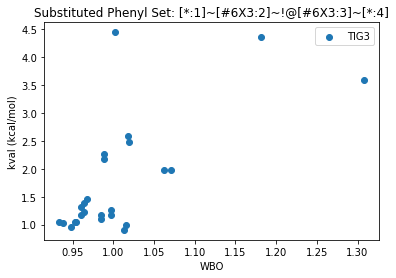

[5.8164895481544425, 7.991749322132638, 8.524147218522462, 2.062177782789626, 22.540852085734226, 5.325365762086769, 7.31859259273895, 9.311533969028108, 2.278882299097802, 6.748641721711576, 8.062759198031708, 6.458453935038053, 17.96499479824482, 6.749664563450633, 2.3068181769886182, 7.907566248822933, 10.366308297621172, 8.185127713480417, 8.569348099804387, 24.607458020009926, 6.640541346262993, 4.1706784979493445, 7.190759969054035, 6.037508322900804, 2.6806446718057364]
[0.9514866066724, 1.310056547371, 2.472249987404, 1.267061154753, 4.347465876997, 2.169815582378, 2.585234082741, 1.454042377312, 1.172427432497, 1.050765820751, 1.970888202854, 1.102358161853, 4.441453309557, 1.055679554521, 0.9052469589192, 1.169400308842, 1.982929893013, 1.226899382478, 1.390721732912, 3.592287677812, 1.033914573346, 2.26981980417, 1.046430219823, 1.178125712195, 0.9860173369155]
['#F0F8FF', '#FAEBD7', '#00FFFF', '#7FFFD4', '#F0FFFF', '#F5F5DC', '#FFE4C4', '#000000', '#FFEBCD', '#0000FF', '#8A

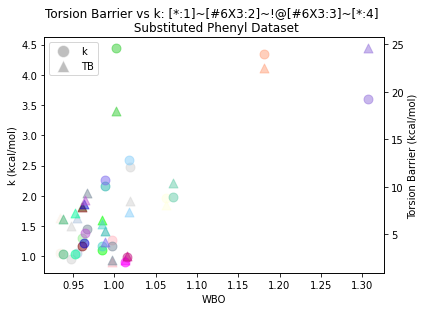

[5.8164895481544425, 7.991749322132638, 8.524147218522462, 2.062177782789626, 22.540852085734226, 5.325365762086769, 7.31859259273895, 9.311533969028108, 2.278882299097802, 6.748641721711576, 8.062759198031708, 6.458453935038053, 17.96499479824482, 6.749664563450633, 2.3068181769886182, 7.907566248822933, 10.366308297621172, 8.185127713480417, 8.569348099804387, 24.607458020009926, 6.640541346262993, 4.1706784979493445, 7.190759969054035, 6.037508322900804, 2.6806446718057364]
[0.9514866066724, 1.310056547371, 2.472249987404, 1.267061154753, 4.347465876997, 2.169815582378, 2.585234082741, 1.454042377312, 1.172427432497, 1.050765820751, 1.970888202854, 1.102358161853, 4.441453309557, 1.055679554521, 0.9052469589192, 1.169400308842, 1.982929893013, 1.226899382478, 1.390721732912, 3.592287677812, 1.033914573346, 2.26981980417, 1.046430219823, 1.178125712195, 0.9860173369155]


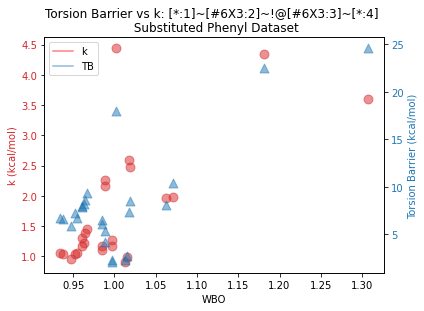

In [8]:


def plot_wbo_vs_k(filename):
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    #print(x)
    
    wbo=[]
    kval=[]
    ids=set()
    
    for key, item in x.items():
        wbo.append(item[0])
        kval.append(item[1])
        ids.add(item[2])
        
    #print(ids)
    
    dataDictWBO={}
    dataDictKval={}
    
    for i in ids:
        dataDictWBO[i]=[]
        dataDictKval[i]=[] 
        
        
    for i in ids:
        for key, item in x.items():
            if item[2]==i:
                dataDictWBO[i].append(item[0])
                dataDictKval[i].append(item[1])
    
    #print(wbo)
    #print(kval)
    for k, item in dataDictWBO.items():
        plt.scatter(dataDictWBO[k], dataDictKval[k], label=k)
    #plt.scatter(wbo, kval)
    plt.xlabel("WBO")
    plt.legend()
    plt.ylabel("kval (kcal/mol)")
    plt.title("Substituted Phenyl Set: [*:1]~[#6X3:2]~!@[#6X3:3]~[*:4]")
    plt.savefig('initialplot_energycompare.pdf')
    plt.show()
    
def plot_wbo_tb_compare(filename):
    
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    #print(x)
    
    wbo=[]
    kval=[]
    tb=[]
    ids=set()
    
    for key, item in x.items():
        wbo.append(item[0])
        kval.append(item[1])
        ids.add(item[2])
        tb.append(item[3]*0.239006)
    #print(ids)
    print(tb)
    print(kval)
    dataDictWBO={}
    dataDictKval={}
    
    for i in ids:
        dataDictWBO[i]=[]
        dataDictKval[i]=[] 
        
        
    for i in ids:
        for key, item in x.items():
            if item[2]==i:
                dataDictWBO[i].append(item[0])
                dataDictKval[i].append(item[1])

    fig, ax1 = plt.subplots()
    colors = list(matplotlib.colors.cnames.values())
    print(colors)
    colors=['#D3D3D3', '#90EE90', '#D3D3D3', '#FFB6C1', '#FFA07A', '#20B2AA', '#87CEFA', '#778899', '#778899', '#B0C4DE', '#FFFFE0', '#00FF00', '#32CD32', '#FAF0E6', '#FF00FF', '#800000', '#66CDAA', '#0000CD', '#BA55D3', '#9370DB', '#3CB371', '#7B68EE', '#00FA9A', '#48D1CC', '#C71585', '#191970', '#F5FFFA', '#FFE4E1', '#FFE4B5', '#FFDEAD', '#000080', '#FDF5E6', '#808000', '#6B8E23', '#FFA500', '#FF4500', '#DA70D6', '#EEE8AA', '#98FB98', '#AFEEEE', '#DB7093', '#FFEFD5', '#FFDAB9', '#CD853F', '#FFC0CB', '#DDA0DD', '#B0E0E6', '#800080', '#663399', '#FF0000', '#BC8F8F', '#4169E1', '#8B4513', '#FA8072', '#F4A460', '#2E8B57', '#FFF5EE', '#A0522D', '#C0C0C0', '#87CEEB', '#6A5ACD', '#708090', '#708090', '#FFFAFA', '#00FF7F', '#4682B4', '#D2B48C', '#008080', '#D8BFD8', '#FF6347', '#40E0D0', '#EE82EE', '#F5DEB3', '#FFFFFF', '#F5F5F5', '#FFFF00', '#9ACD32']
    
    j=3
    for i, val in enumerate(wbo):
        ax1.scatter(wbo[i], kval[i], color=colors[i], marker='o', s=80, alpha=.5)
        
    color = 'tab:red'
    ax1.set_xlabel("WBO")
    ax1.set_ylabel("k (kcal/mol)")
    #ax1.scatter(wbo, kval, color=color)
    ax1.tick_params(axis='y')
    #ax1.legend()
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    
    #ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    
    for i, val in enumerate(wbo):
        ax2.scatter(wbo[i], tb[i], color=colors[i], marker='^', s=80, alpha=.5)
    
    #ax2.scatter(wbo, tb, color=color)
    ax2.tick_params(axis='y')
    ax2.set_ylabel('Torsion Barrier (kcal/mol)')
    
    #ax2.legend()
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    
    marks = [
                   Line2D([0], [0], marker='o', color='w', label='k',
                          markerfacecolor='grey', markersize=12, alpha=.5),
             Line2D([0], [0], marker='^', color='w', label='TB',
                          markerfacecolor='grey', markersize=12, alpha=.5)]

    plt.legend(handles=marks)
        
    plt.title("Torsion Barrier vs k: [*:1]~[#6X3:2]~!@[#6X3:3]~[*:4] \n Substituted Phenyl Dataset")
    plt.savefig('tbvsk.pdf', bbox_inches='tight')
    
    plt.show()
    
def plot_wbo_tb_compare_solid(filename):
    
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    #print(x)
    
    wbo=[]
    kval=[]
    tb=[]
    ids=set()
    
    for key, item in x.items():
        wbo.append(item[0])
        kval.append(item[1])
        ids.add(item[2])
        tb.append(item[3]*0.239006)
    #print(ids)
    print(tb)
    print(kval)
    dataDictWBO={}
    dataDictKval={}
    
    for i in ids:
        dataDictWBO[i]=[]
        dataDictKval[i]=[] 
        
        
    for i in ids:
        for key, item in x.items():
            if item[2]==i:
                dataDictWBO[i].append(item[0])
                dataDictKval[i].append(item[1])

    fig, ax1 = plt.subplots()
    colors = list(matplotlib.colors.cnames.values())
    
    #for i, val in enumerate(wbo):
    #    ax1.scatter(wbo[i], kval[i], color=colors[i], marker='o', s=50, alpha=.5)
    color = 'tab:red'
    ax1.scatter(wbo, kval, color=color, marker='o', s=80, alpha=.5, label="k")
    ax1.set_xlabel("WBO")
    ax1.set_ylabel("k (kcal/mol)", color=color)
    #ax1.scatter(wbo, kval, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    #color=['#ffb3ba']
    #ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    
    
    #ax1.scatter(wbo, tb, color=color, marker='^', s=50, alpha=.5)
    
    ax2.scatter(wbo, tb, color=color, marker='^', s=80, alpha=.5, label="TB")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Torsion Barrier (kcal/mol)', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    elements=[Line2D([0], [0], color='red', label='k',markerfacecolor='red', markersize=15, alpha=.5),Line2D([0], [0], color=color, label='TB', markersize=15, alpha=.5) ]
    plt.legend(handles=elements)
    plt.title("Torsion Barrier vs k: [*:1]~[#6X3:2]~!@[#6X3:3]~[*:4] \n Substituted Phenyl Dataset")
    
    plt.savefig('tbvsk_solidcolor.pdf', bbox_inches='tight')

    plt.show()
    
    

plot_wbo_vs_k('plot_k_wbo.pk')
plot_wbo_tb_compare('plot_k_wbo.pk')
plot_wbo_tb_compare_solid('plot_k_wbo.pk')
        

In [9]:
with gzip.open('sterics_data.pkl', 'rb') as f:
    lj = pickle.load(f)
print(lj.columns)
print(lj['LJ energy diff kcal/mol'])
print('keys',lj['LJ energy diff kcal/mol'].keys())
print('energy',lj['LJ energy diff kcal/mol']['1762227'])


ID=['18537025', '3745392', '3745370', '18886248', '18536199', '18045331', '18535845', '18886245', '18535848', '18537010', '4269710', '18537009', '18537022', '4269708', '4269709', '19953582', '18045328', '18537012', '18537008', '18537018', '4269707', '3745476', '18536057', '18536192', '18045333', '4269712', '18535844', '18886247', '3745617', '18045330', '18537019', '6098536', '18886246', '18886237', '4269703', '18536064', '18535839', '19953583', '6098519', '18886249', '18536061', '19953581', '3745367', '18536065', '4269711', '3745366', '18537017', '4269706', '3745658', '3745390', '18535843', '18537023', '18535849', '4269704', '3745541', '18535838', '19953579', '3745391', '19953580', '18537021', '18886244', '18886238', '18537027', '18537026', '18535846', '18535842', '18886243', '18537020', '18536062', '18536201', '4269705', '18535847', '18536063', '18536056']
#for i in ID:
#    print(lj['LJ energy diff kcal/mol'][i])
pk_keys = lj['LJ energy diff kcal/mol'].keys()
append_list = []
nomatch=[]
for i in ID:
    if i in pk_keys:
        append_list.append(i)
    else:
        nomatch.append(i)
print('match', append_list)
print('no match', nomatch)

        

#print(lj['LJ energy diff kcal/mol']['18537025'])

#kwbo_dict[cmiles]={'wbo': wborder, 'kval': kval[os.path.basename(asub)], 'id': parameter_match, 'tb':getTB(elist), 'tid':TID}


def plot_wbo_tb_compare_solid(filename):
    
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    #print(x)
    
    wbo=[]
    kval=[]
    tb=[]
    ids=set()
    tid=[]
    #print('debug', [(key,item) for key,item in x.items()])
    #print(x)
    tids=['3745392', '3745370', '18535845', '18535848', '4269710', '4269708', '4269709', '19953582', '18045328', '4269707', '3745476', '18536057', '18045333', '4269712', '18886247', '3745617', '18045330', '18537019', '18886237', '4269703', '18536064', '18535839', '19953583', '18886249', '18536061', '19953581', '3745367', '4269711', '3745366', '4269706', '3745658', '3745390', '18535849', '4269704', '3745541', '18535838', '19953579', '3745391', '19953580', '18886244', '18886238', '18535846', '18535842', '18886243', '18536062', '18536201', '4269705', '18535847', '18536063', '18536056']
    
    print(x)
    
    for key, item in x.items():
        if item['tid'] in tids:
            if lj['LJ energy diff kcal/mol'][item['tid']]<3.4:
                #print("Not filtered")
                wbo.append(item['wbo'])
                kval.append(item['kval'])
                ids.add(item['id'])
                tid.append(item['tid'])
                tb.append(item['tb']*0.239006)
    #print(ids)
    #print(tid)
    #print(tb)
    #print(kval)
    dataDictWBO={}
    dataDictKval={}
    
    #print(ids)

    
    for i in ids:
        dataDictWBO[i]=[]
        dataDictKval[i]=[] 
        
        
    #print(x)
    for i in ids:
        for key, item in x.items():
            #print(item)
            #print(key)
            #print(item['id'])
            #print(i)
            if item['id']==i:
                dataDictWBO[i].append(item['wbo'])
                dataDictKval[i].append(item['kval'])

    fig, ax1 = plt.subplots()
    colors = list(matplotlib.colors.cnames.values())
    
    #for i, val in enumerate(wbo):
    #    ax1.scatter(wbo[i], kval[i], color=colors[i], marker='o', s=50, alpha=.5)
    color = 'tab:red'
    ax1.scatter(wbo, kval, color=color, marker='o', s=80, alpha=.5, label="k")
    
    error=[]
    for k, t in zip(kval, tb):
        error.append(k-(t/4))
    print(error)
    ax1.errorbar(wbo, kval, yerr=error, fmt='none', color=color, alpha=.5)
    
    ax1.set_xlabel("WBO")
    ax1.set_ylabel("k (kcal/mol)", color=color)
    #ax1.scatter(wbo, kval, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    #color=['#ffb3ba']
    #ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    
    
    #ax1.scatter(wbo, tb, color=color, marker='^', s=50, alpha=.5)
    
    ax2.scatter(wbo, tb, color=color, marker='^', s=80, alpha=.5, label="TB")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Torsion Barrier (kcal/mol)', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    elements=[Line2D([0], [0], color='red', label='k',markerfacecolor='red', markersize=15, alpha=.5),Line2D([0], [0], color=color, label='TB', markersize=15, alpha=.5) ]
    
    
    
    plt.legend(handles=elements)
    plt.title("Torsion Barrier vs k: [*:1]~[#6X3:2]~!@[#6X3:3]~[*:4] \n 1.2.0 training & subtituted phenyl datasets")
    
    plt.savefig('tbvsk_solidcolor.pdf', bbox_inches='tight')

    plt.show()
    
def plot_wbo_tb_compare_solid_noerrorbar(filename):
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    #print(x)
    
    wbo=[]
    kval=[]
    tb=[]
    ids=set()
    tid=[]
    #print('debug', [(key,item) for key,item in x.items()])
    #print(x)
    tids=['3745392', '3745370', '18535845', '18535848', '4269710', '4269708', '4269709', '19953582', '18045328', '4269707', '3745476', '18536057', '18045333', '4269712', '18886247', '3745617', '18045330', '18537019', '18886237', '4269703', '18536064', '18535839', '19953583', '18886249', '18536061', '19953581', '3745367', '4269711', '3745366', '4269706', '3745658', '3745390', '18535849', '4269704', '3745541', '18535838', '19953579', '3745391', '19953580', '18886244', '18886238', '18535846', '18535842', '18886243', '18536062', '18536201', '4269705', '18535847', '18536063', '18536056']

    for key, item in x.items():
        if item['tid'] in tids:
            if lj['LJ energy diff kcal/mol'][item['tid']]<3.4:
                #print("Not filtered")
                wbo.append(item['wbo'])
                kval.append(item['kval'])
                ids.add(item['id'])
                tid.append(item['tid'])
                tb.append(item['tb']*0.239006)
    #print(ids)
    #print(tid)
    #print(tb)
    #print(kval)
    dataDictWBO={}
    dataDictKval={}
    
    #print(ids)

    
    for i in ids:
        dataDictWBO[i]=[]
        dataDictKval[i]=[] 
        
        
    #print(x)
    for i in ids:
        for key, item in x.items():
            #print(item)
            #print(key)
            #print(item['id'])
            #print(i)
            if item['id']==i:
                dataDictWBO[i].append(item['wbo'])
                dataDictKval[i].append(item['kval'])

    fig, ax1 = plt.subplots()
    colors = list(matplotlib.colors.cnames.values())
    
    #for i, val in enumerate(wbo):
    #    ax1.scatter(wbo[i], kval[i], color=colors[i], marker='o', s=50, alpha=.5)
    color = 'tab:red'
    ax1.scatter(wbo, kval, color=color, marker='o', s=80, alpha=.5, label="k")
    
    #ax1.errorbar(wbo, kval, yerr=error, fmt='none', color=color, alpha=.5)
    
    ax1.set_xlabel("WBO")
    ax1.set_ylabel("k (kcal/mol)", color=color)
    #ax1.scatter(wbo, kval, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    #color=['#ffb3ba']
    #ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    
    
    #ax1.scatter(wbo, tb, color=color, marker='^', s=50, alpha=.5)
    
    ax2.scatter(wbo, tb, color=color, marker='^', s=80, alpha=.5, label="TB")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Torsion Barrier (kcal/mol)', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    elements=[Line2D([0], [0], color='red', label='k',markerfacecolor='red', markersize=15, alpha=.5),Line2D([0], [0], color=color, label='TB', markersize=15, alpha=.5) ]
    
    
    
    plt.legend(handles=elements)
    plt.title("Torsion Barrier vs k: [*:1]~[#6X3:2]~!@[#6X3:3]~[*:4] \n 1.2.0 training & subtituted phenyl datasets")
    
    plt.savefig('tbvsk_solidcolor_noerror_bar_steric_filter.pdf', bbox_inches='tight')

    plt.show()  

plot_wbo_tb_compare_solid('plot_k_wbo_dict.pk')
plot_wbo_tb_compare_solid_noerrorbar('plot_k_wbo_dict.pk')

Index(['LJ energy diff kcal/mol', 'MM diff at QM_high and QM_low kcal/mol',
       '(QM high - QM low) kcal/mol', 'Chemical Structure',
       'QM-MM relative energies'],
      dtype='object')
Torsion ID
2703072     -0.000946
2703070      0.001468
2703083      0.002163
2703079      0.003568
2703078      0.005925
              ...    
1762227    -17.937302
21272413    19.368013
21272392    19.903815
21272410    21.827095
1762111     21.894760
Name: LJ energy diff kcal/mol, Length: 844, dtype: float64
keys Index(['2703072', '2703070', '2703083', '2703079', '2703078', '2703077',
       '2703081', '21272420', '1791748', '1762673',
       ...
       '21272384', '1762828', '1762107', '1762266', '1762228', '1762227',
       '21272413', '21272392', '21272410', '1762111'],
      dtype='object', name='Torsion ID', length=844)
energy -17.937302067124808
match ['3745392', '3745370', '18535845', '18535848', '4269710', '4269708', '4269709', '19953582', '18045328', '4269707', '3745476', '18536057', '

/Users/jessica/miniconda3/envs/fbruns/lib/python3.7/site-packages/ipykernel_launcher.py:123: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/Users/jessica/miniconda3/envs/fbruns/lib/python3.7/site-packages/ipykernel_launcher.py:211: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [ ]:
with gzip.open('sterics_data.pkl', 'rb') as f:
    lj = pickle.load(f)
print(lj.columns)
print(lj['LJ energy diff kcal/mol'])
print('keys',lj['LJ energy diff kcal/mol'].keys())
print('energy',lj['LJ energy diff kcal/mol']['1762227'])


ID=['18537025', '3745392', '3745370', '18886248', '18536199', '18045331', '18535845', '18886245', '18535848', '18537010', '4269710', '18537009', '18537022', '4269708', '4269709', '19953582', '18045328', '18537012', '18537008', '18537018', '4269707', '3745476', '18536057', '18536192', '18045333', '4269712', '18535844', '18886247', '3745617', '18045330', '18537019', '6098536', '18886246', '18886237', '4269703', '18536064', '18535839', '19953583', '6098519', '18886249', '18536061', '19953581', '3745367', '18536065', '4269711', '3745366', '18537017', '4269706', '3745658', '3745390', '18535843', '18537023', '18535849', '4269704', '3745541', '18535838', '19953579', '3745391', '19953580', '18537021', '18886244', '18886238', '18537027', '18537026', '18535846', '18535842', '18886243', '18537020', '18536062', '18536201', '4269705', '18535847', '18536063', '18536056']
#for i in ID:
#    print(lj['LJ energy diff kcal/mol'][i])
pk_keys = lj['LJ energy diff kcal/mol'].keys()
append_list = []
nomatch=[]
for i in ID:
    if i in pk_keys:
        append_list.append(i)
    else:
        nomatch.append(i)
print('match', append_list)
print('no match', nomatch)

        

#print(lj['LJ energy diff kcal/mol']['18537025'])

#kwbo_dict[cmiles]={'wbo': wborder, 'kval': kval[os.path.basename(asub)], 'id': parameter_match, 'tb':getTB(elist), 'tid':TID}


def plot_wbo_tb_compare_solid(filename):
    
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    #print(x)
    
    wbo=[]
    kval=[]
    tb=[]
    ids=set()
    tid=[]
    #print('debug', [(key,item) for key,item in x.items()])
    #print(x)
    tids=['3745392', '3745370', '18535845', '18535848', '4269710', '4269708', '4269709', '19953582', '18045328', '4269707', '3745476', '18536057', '18045333', '4269712', '18886247', '3745617', '18045330', '18537019', '18886237', '4269703', '18536064', '18535839', '19953583', '18886249', '18536061', '19953581', '3745367', '4269711', '3745366', '4269706', '3745658', '3745390', '18535849', '4269704', '3745541', '18535838', '19953579', '3745391', '19953580', '18886244', '18886238', '18535846', '18535842', '18886243', '18536062', '18536201', '4269705', '18535847', '18536063', '18536056']
    
    #print(x)
    
    
    
    for key, item in x.items():
        if item['tid'] in tids:
            if lj['LJ energy diff kcal/mol'][item['tid']]<3.4:
                #print("Not filtered")
                wbo.append(item['wbo'])
                kval.append(item['kval'])
                ids.add(item['id'])
                tid.append(item['tid'])
                tb.append(item['tb']*0.239006)
    #print(ids)
    #print(tid)
    #print(tb)
    #print(kval)
    dataDictWBO={}
    dataDictKval={}
    
    #print(ids)

    
    for i in ids:
        dataDictWBO[i]=[]
        dataDictKval[i]=[] 
        
        
    #print(x)
    for i in ids:
        for key, item in x.items():
            #print(item)
            #print(key)
            #print(item['id'])
            #print(i)
            if item['id']==i:
                dataDictWBO[i].append(item['wbo'])
                dataDictKval[i].append(item['kval'])

    fig, ax1 = plt.subplots()
    colors = list(matplotlib.colors.cnames.values())
    
    #for i, val in enumerate(wbo):
    #    ax1.scatter(wbo[i], kval[i], color=colors[i], marker='o', s=50, alpha=.5)
    color = 'tab:red'
    ax1.scatter(wbo, kval, color=color, marker='o', s=80, alpha=.5, label="k")
    
    error=[]
    for k, t in zip(kval, tb):
        error.append(k-(t/4))
    print(error)
    ax1.errorbar(wbo, kval, yerr=error, fmt='none', color=color, alpha=.5)
    
    ax1.set_xlabel("WBO")
    ax1.set_ylabel("k (kcal/mol)", color=color)
    #ax1.scatter(wbo, kval, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    #color=['#ffb3ba']
    #ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    
    
    #ax1.scatter(wbo, tb, color=color, marker='^', s=50, alpha=.5)
    
    ax2.scatter(wbo, tb, color=color, marker='^', s=80, alpha=.5, label="TB")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Torsion Barrier (kcal/mol)', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    elements=[Line2D([0], [0], color='red', label='k',markerfacecolor='red', markersize=15, alpha=.5),Line2D([0], [0], color=color, label='TB', markersize=15, alpha=.5) ]
    
    
    
    plt.legend(handles=elements)
    plt.title("Torsion Barrier vs k: [*:1]~[#6X3:2]~!@[#6X3:3]~[*:4] \n 1.2.0 training & subtituted phenyl datasets")
    
    plt.savefig('tbvsk_solidcolor.pdf', bbox_inches='tight')

    plt.show()
    
def plot_wbo_tb_compare_solid_noerrorbar(filename):
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    #print(x)
    
    wbo=[]
    kval=[]
    tb=[]
    ids=set()
    tid=[]
    #print('debug', [(key,item) for key,item in x.items()])
    #print(x)
    tids=['3745392', '3745370', '18535845', '18535848', '4269710', '4269708', '4269709', '19953582', '18045328', '4269707', '3745476', '18536057', '18045333', '4269712', '18886247', '3745617', '18045330', '18537019', '18886237', '4269703', '18536064', '18535839', '19953583', '18886249', '18536061', '19953581', '3745367', '4269711', '3745366', '4269706', '3745658', '3745390', '18535849', '4269704', '3745541', '18535838', '19953579', '3745391', '19953580', '18886244', '18886238', '18535846', '18535842', '18886243', '18536062', '18536201', '4269705', '18535847', '18536063', '18536056']

    for key, item in x.items():
        if item['tid'] in tids:
            if lj['LJ energy diff kcal/mol'][item['tid']]<3.4:
                #print("Not filtered")
                wbo.append(item['wbo'])
                kval.append(item['kval'])
                ids.add(item['id'])
                tid.append(item['tid'])
                tb.append(item['tb']*0.239006)
    #print(ids)
    #print(tid)
    #print(tb)
    #print(kval)
    dataDictWBO={}
    dataDictKval={}
    
    #print(ids)

    
    for i in ids:
        dataDictWBO[i]=[]
        dataDictKval[i]=[] 
        
        
    #print(x)
    for i in ids:
        for key, item in x.items():
            #print(item)
            #print(key)
            #print(item['id'])
            #print(i)
            if item['id']==i:
                dataDictWBO[i].append(item['wbo'])
                dataDictKval[i].append(item['kval'])

    fig, ax1 = plt.subplots()
    colors = list(matplotlib.colors.cnames.values())
    
    #for i, val in enumerate(wbo):
    #    ax1.scatter(wbo[i], kval[i], color=colors[i], marker='o', s=50, alpha=.5)
    color = 'tab:red'
    ax1.scatter(wbo, kval, color=color, marker='o', s=80, alpha=.5, label="k")
    
    #ax1.errorbar(wbo, kval, yerr=error, fmt='none', color=color, alpha=.5)
    
    ax1.set_xlabel("WBO")
    ax1.set_ylabel("k (kcal/mol)", color=color)
    #ax1.scatter(wbo, kval, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    #color=['#ffb3ba']
    #ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    
    
    #ax1.scatter(wbo, tb, color=color, marker='^', s=50, alpha=.5)
    
    ax2.scatter(wbo, tb, color=color, marker='^', s=80, alpha=.5, label="TB")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Torsion Barrier (kcal/mol)', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    elements=[Line2D([0], [0], color='red', label='k',markerfacecolor='red', markersize=15, alpha=.5),Line2D([0], [0], color=color, label='TB', markersize=15, alpha=.5) ]
    
    
    
    plt.legend(handles=elements)
    plt.title("Torsion Barrier vs k: [*:1]~[#6X3:2]~!@[#6X3:3]~[*:4] \n 1.2.0 training & subtituted phenyl datasets")
    
    plt.savefig('tbvsk_solidcolor_noerror_bar_steric_filter.pdf', bbox_inches='tight')

    plt.show()  

plot_wbo_tb_compare_solid('plot_k_wbo_dict.pk')
plot_wbo_tb_compare_solid_noerrorbar('plot_k_wbo_dict.pk')

In [22]:
import gzip
from openeye import oechem

# Highlight element of interest
#subs = oechem.OESubSearch("[#6]") # carbon
subs = None

# Read the input SMILES
with open('optimization_inputs.smi', 'r') as infile:
    smiles_list = infile.readlines()
smiles_list = [ smiles.strip() for smiles in smiles_list ]

with open(filename, 'rb') as f:
    x = pickle.load(f)
print(x)


# Build OEMols
oemols = list()
for smiles in smiles_list:
    oemol = oechem.OEMol()
    oechem.OESmilesToMol(oemol, smiles)
    oemols.append(oemol)

# Generate a PDF of all molecules in the set
pdf_filename = 'optimization_inputs.pdf'

from openeye import oedepict
itf = oechem.OEInterface()
PageByPage = True
suppress_h = True
rows = 10
cols = 6
ropts = oedepict.OEReportOptions(rows, cols)
ropts.SetHeaderHeight(25)
ropts.SetFooterHeight(25)
ropts.SetCellGap(2)
ropts.SetPageMargins(10)
report = oedepict.OEReport(ropts)
cellwidth, cellheight = report.GetCellWidth(), report.GetCellHeight()
opts = oedepict.OE2DMolDisplayOptions(cellwidth, cellheight, oedepict.OEScale_Default * 0.5)
opts.SetAromaticStyle(oedepict.OEAromaticStyle_Circle)
pen = oedepict.OEPen(oechem.OEBlack, oechem.OEBlack, oedepict.OEFill_On, 1.0)
opts.SetDefaultBondPen(pen)
oedepict.OESetup2DMolDisplayOptions(opts, itf)
for i, mol in enumerate(oemols):
    cell = report.NewCell()
    mol_copy = oechem.OEMol(mol)
    oedepict.OEPrepareDepiction(mol_copy, False, suppress_h)
    disp = oedepict.OE2DMolDisplay(mol_copy, opts)

    # Highlight element of interest
    unique = False
    if subs is not None:
        for match in subs.Match(mol_copy, unique):
            oedepict.OEAddHighlighting(disp, oechem.OEColor(oechem.OEYellow), oedepict.OEHighlightStyle_BallAndStick, match)

    oedepict.OERenderMolecule(cell, disp)
    #oedepict.OEDrawCurvedBorder(cell, oedepict.OELightGreyPen, 10.0)

oedepict.OEWriteReport(pdf_filename, report)


heavyAtomCount=[]
atoms=[]
for mol in oemols:
    heavyAtomCount.append(oechem.OECount(mol, oechem.OEIsHeavy()))
#    atoms.append(oechem.OECount(mol, oechem.GetExplicitDegree()))
print(heavyAtomCount)
print(min(heavyAtomCount))
print(max(heavyAtomCount))


#print(atoms)
#print(min(atoms))
#print(max(atoms))

FileNotFoundError: [Errno 2] No such file or directory: 'optimization_inputs.smi'

In [ ]:
adict = readKval()
print(adict)

In [38]:
import xml

In [40]:
print(dir(xml.etree))

['ElementPath', 'ElementTree', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [42]:
import xml.etree.ElementTree as ET
root = ET.parse('debug.tmp/td_OpenFF_Substituted_Phenyl_Set_1_152_C11ClH8NO/iter_0001/test.offxml').getroot()
all_name_elements = tree.findall('*/name')


<Element 'SMIRNOFF' at 0x7fd4bd1c9d10>


In [73]:
tree = ET.parse('debug.tmp/td_OpenFF_Substituted_Phenyl_Set_1_152_C11ClH8NO/iter_0001/test.offxml').getroot()

In [74]:
all_name_elements = tree.findall('*/TIG-fit0')
print(all_name_elements)

[]


In [60]:
print(dir(tree))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_root', '_setroot', 'find', 'findall', 'findtext', 'getiterator', 'getroot', 'iter', 'iterfind', 'parse', 'write', 'write_c14n']


In [37]:
cd ../../

/Users/jessica/Documents/Grad_research/wbointerpolation/by_molecule_experiment/fb-fit0


In [5]:
plot_data = collect_td_targets_data('debug.tmp', 'targets')


match 25
target 25
0 td_OpenFF_Substituted_Phenyl_Set_1_009_C11H13NO3
1 td_OpenFF_Substituted_Phenyl_Set_1_010_C11H17N2O2
2 td_OpenFF_Substituted_Phenyl_Set_1_013_C10H13NO3
3 td_OpenFF_Substituted_Phenyl_Set_1_032_C8H10N2O2
4 td_OpenFF_Substituted_Phenyl_Set_1_033_C9H10O3
5 td_OpenFF_Substituted_Phenyl_Set_1_034_C9H12N2O2
6 td_OpenFF_Substituted_Phenyl_Set_1_056_C7H8N2O2
7 td_OpenFF_Substituted_Phenyl_Set_1_084_C9H13N2O2
8 td_OpenFF_Substituted_Phenyl_Set_1_131_C7H4N2O2
9 td_OpenFF_Substituted_Phenyl_Set_1_139_C8H8N2O3
10 td_OpenFF_Substituted_Phenyl_Set_1_141_C11H10NO
11 td_OpenFF_Substituted_Phenyl_Set_1_142_C11H9NO
12 td_OpenFF_Substituted_Phenyl_Set_1_143_C11H9NO
13 td_OpenFF_Substituted_Phenyl_Set_1_144_C11H8NO
14 td_OpenFF_Substituted_Phenyl_Set_1_145_C11FH9NO
15 td_OpenFF_Substituted_Phenyl_Set_1_146_C11FH8NO
16 td_OpenFF_Substituted_Phenyl_Set_1_147_C11FH8NO
17 td_OpenFF_Substituted_Phenyl_Set_1_148_C11FH7NO
18 td_OpenFF_Substituted_Phenyl_Set_1_149_C11H9N
19 td_OpenFF_Substitu